# NOTE: LSN analysis is still in its early phase and is by no means comprehensive

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis import LocallySparseNoise

%load_ext autoreload
%autoreload 2

In [2]:
# windows
# base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data"

# # linux and mac
# base_folder = "/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
# base_folder = "/Volumes/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
base_folder = "/Users/chase/Desktop/test_v1dd_data"
client = OPhysClient(base_folder)

In [3]:
mouse = 409828
col, vol = 1, 3
sess = client.load_ophys_session(mouse=mouse, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [4]:
plane = sess.get_planes()[0]
print(f"Analyzing plane {plane}")

Analyzing plane 1


In [5]:
# lsn = LocallySparseNoise(sess, plane, trace_type="events")
lsn = LocallySparseNoise(sess, plane, trace_type="dff")

In [6]:
lsn.stim_table.head()

,start,end,frame
0,635.117737,635.417969,0
1,635.434692,635.734924,1
2,635.751587,636.051819,2
3,636.068481,636.368774,3
4,636.385437,636.685791,4


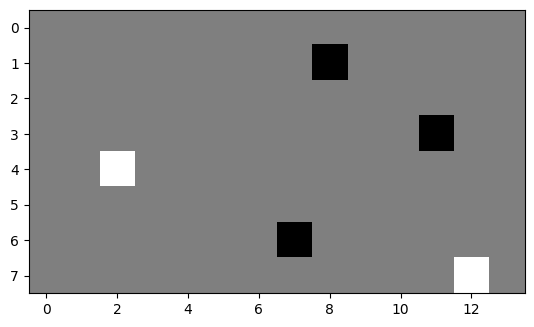

In [7]:
plt.imshow(lsn.frame_images[0], cmap="gray")

# Computing receptive fields

In [35]:

# Now put in lsn.sweep_responses
# def get_stim_sweep_events(lsn, events, timestamps, method="mean"):
#     # Assumes events and timestamps are 1d arrays corresponding to a single ROI
#     stim_sweep_events = []

#     for stim_i, stim in lsn.stim_table.iterrows():
#         start = find_nearest(timestamps, stim["start"], direction=-1)
#         end = find_nearest(timestamps, stim["end"])
#         mean_event = events[start:end+1].mean()

#         if method == "mean":
#             event = mean_event
#         elif method == "binary":
#             event = mean_event > 0
#         else:
#             event = None

#         stim_sweep_events.append(event)

#     stim_sweep_events = np.array(stim_sweep_events)
#     return stim_sweep_events


def get_sta(lsn, design_matrix, sweep_events):
    sta = design_matrix.dot(sweep_events)
    image_shape = lsn.frame_images.shape[1:]
    sta_on = sta[:lsn.n_pixels].reshape(image_shape)
    sta_off = sta[lsn.n_pixels:].reshape(image_shape)

    return sta_on, sta_off



def get_greedy_pixelwise_pvals(lsn, design_matrix, sweep_events, alpha=0.05):
    p_values = events_to_pvals_no_fdr_correction(lsn, sweep_events, design_matrix)
    
    # Correct for multiple comparisons across all pixels (Holm-Sidak)
    if alpha is not None:
        from statsmodels.sandbox.stats.multicomp import multipletests
        p_values = multipletests(p_values, alpha=alpha)[1]

    # Convert to 2d pixel array
    image_shape = lsn.frame_images.shape[1:]
    p_values_on = p_values[:lsn.n_pixels].reshape(image_shape)
    p_values_off = p_values[lsn.n_pixels:].reshape(image_shape)

    return p_values_on, p_values_off


def get_shuffled_pixelwise_responses(lsn, sweep_events, design_matrix, n_shuffles=5000, seed=1):
    np.random.seed(seed)
    shuffled_stas = np.zeros((design_matrix.shape[0], n_shuffles))
    
    for i in range(n_shuffles):
        random_stim_idx = np.random.randint(low=0, high=lsn.n_sweeps, size=lsn.n_sweeps)
        shuffled_events = sweep_events[random_stim_idx]
        shuffled_stas[:, i] = design_matrix.dot(shuffled_events)

    return shuffled_stas


def events_to_pvals_no_fdr_correction(lsn, sweep_events, design_matrix, n_shuffles=5000, seed=1):
    shuffled_stas = get_shuffled_pixelwise_responses(lsn, sweep_events, design_matrix, n_shuffles=n_shuffles, seed=seed)

    # p values are the fraction of times the shuffled response at each pixel is greater than
    # the actual observed response to that pixel
    sta = design_matrix.dot(sweep_events)
    p_values = np.mean(shuffled_stas > sta.reshape(-1, 1), axis=1)
    return p_values

In [36]:
def plot_rf(ax, roi, rf, is_on, desc="", **kwargs):
    ax.imshow(rf, cmap=("Reds" if is_on else "Blues"), interpolation="none", origin="lower", **kwargs)
    ax.set_xticks(ticks=[x for x in range(len(lsn.azimuths))], labels=[f"{azi:.0f}" for azi in lsn.azimuths])
    ax.set_yticks(ticks=[y for y in range(len(lsn.altitudes))], labels=[f"{alt:.0f}" for alt in lsn.altitudes])
    ax.set_xlabel("Azimuth (°)", fontsize=12)
    ax.set_ylabel("Altitude (°)", fontsize=12)
    ax.set_title(f"ROI {roi} {'ON' if is_on else 'OFF'} receptive field ({desc})", color=("red" if is_on else "blue"))

Design matrix shape (224, 1705)
Sweep events shape (224, 1705)

ROI 16 in plane 1

ROI 17 in plane 1


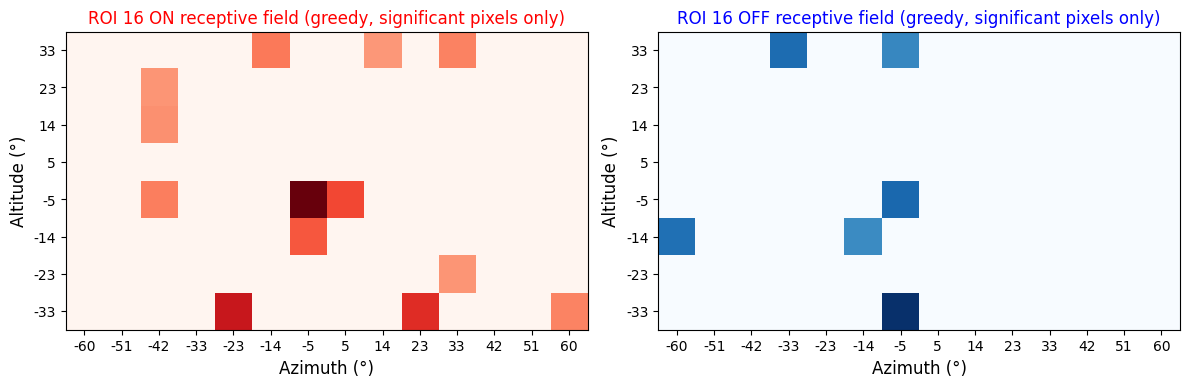

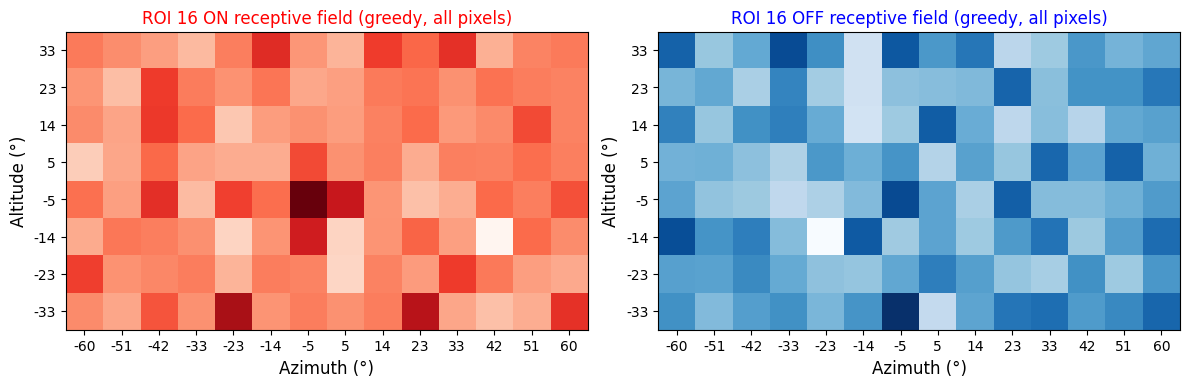

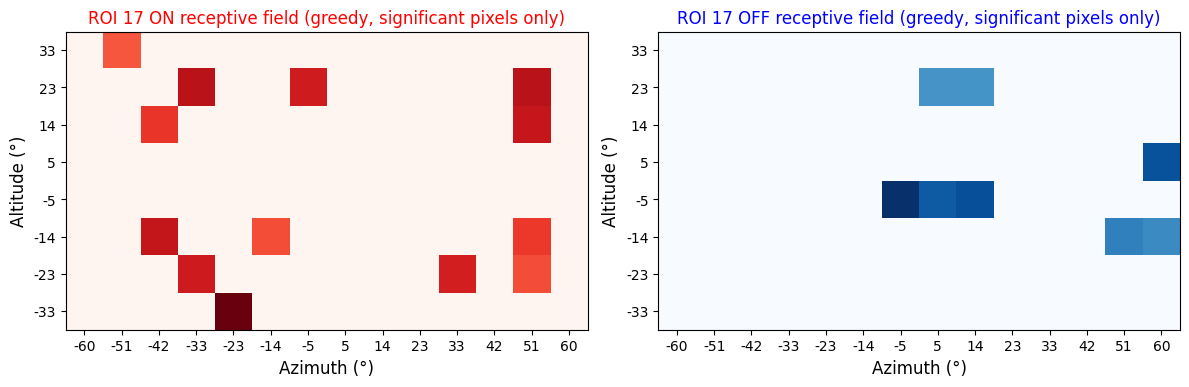

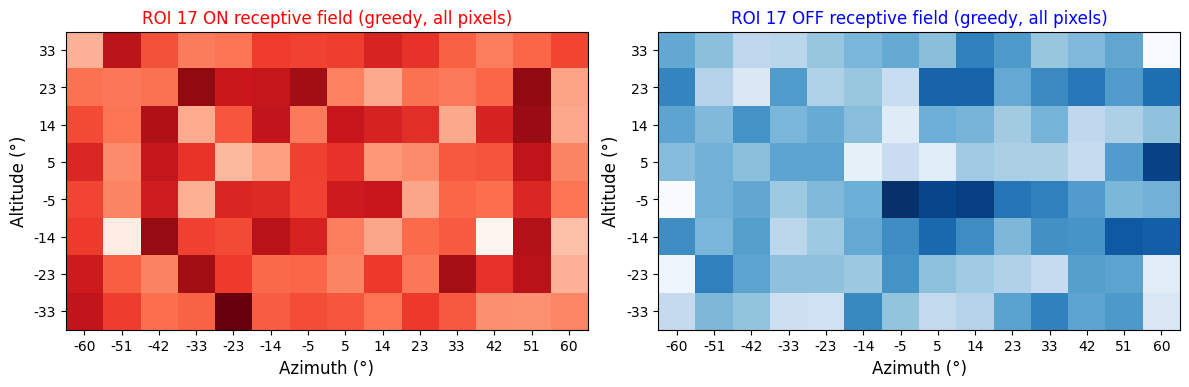

In [37]:
alpha = 0.05
design_matrix = lsn.design_matrix
print("Design matrix shape", design_matrix.shape)
print("Sweep events shape", design_matrix.shape)

# for roi in np.where(sess.is_roi_valid(plane=plane))[0][40:45]:
for roi in [16, 17]:
    # sweep_events = get_stim_sweep_events(lsn, events[roi], timestamps)
    sweep_events = lsn.sweep_responses[:, roi]
    # sweep_events = np.where(sweep_events > 0, sweep_events, 0)
    sta_on, sta_off = get_sta(lsn, design_matrix, sweep_events)
    # print("STA ON shape", sta_on.shape)
    # print("STA OFF shape", sta_off.shape)

    # Apply mask to get only the significant pixels of the STA
    pvals_on, pvals_off = get_greedy_pixelwise_pvals(lsn, design_matrix, sweep_events, alpha=None)
    rf_on = sta_on * (pvals_on < alpha)
    rf_off = sta_off * (pvals_off < alpha)

    print()
    print(f"ROI {roi} in plane {lsn.plane}")
    fig, (ax_on, ax_off) = plt.subplots(ncols=2, figsize=(12, 6))
    plot_rf(ax_on, roi, rf_on, True, "greedy, significant pixels only")
    plot_rf(ax_off, roi, rf_off, False, "greedy, significant pixels only")
    fig.tight_layout()

    fig, (ax_on, ax_off) = plt.subplots(ncols=2, figsize=(12, 6))
    # plot_rf(ax_on, roi, pvals_on, True, "greedy, all pixels", vmin=0, vmax=1)
    # plot_rf(ax_off, roi, pvals_off, False, "greedy, all pixels", vmin=0, vmax=1)
    plot_rf(ax_on, roi, sta_on, True, "greedy, all pixels")
    plot_rf(ax_off, roi, sta_off, False, "greedy, all pixels")
    fig.tight_layout()

In [38]:
pvals_off

array([[0.9088, 0.5802, 0.6922, 0.9432, 0.9462, 0.1784, 0.6928, 0.904 ,
        0.8538, 0.3756, 0.146 , 0.3806, 0.2776, 0.9728],
       [0.9924, 0.1352, 0.3912, 0.6652, 0.6778, 0.7438, 0.234 , 0.67  ,
        0.765 , 0.8294, 0.9072, 0.3522, 0.3936, 0.9816],
       [0.199 , 0.5634, 0.3438, 0.8794, 0.7428, 0.4418, 0.2078, 0.0518,
        0.211 , 0.5856, 0.225 , 0.262 , 0.0262, 0.0386],
       [0.9972, 0.5234, 0.4124, 0.7376, 0.591 , 0.4728, 0.0024, 0.0112,
        0.0066, 0.0924, 0.135 , 0.3184, 0.5764, 0.5178],
       [0.6228, 0.5244, 0.6488, 0.3908, 0.3796, 0.988 , 0.9298, 0.9812,
        0.7562, 0.7932, 0.8014, 0.915 , 0.3182, 0.0094],
       [0.3934, 0.5978, 0.2436, 0.571 , 0.4498, 0.6424, 0.9816, 0.4982,
        0.541 , 0.7524, 0.5424, 0.8918, 0.8198, 0.6742],
       [0.1526, 0.8438, 0.9776, 0.3066, 0.8326, 0.7104, 0.9308, 0.0464,
        0.043 , 0.4334, 0.1788, 0.1004, 0.327 , 0.0746],
       [0.429 , 0.657 , 0.889 , 0.8776, 0.7106, 0.5468, 0.4298, 0.6544,
        0.1342, 0.3016, 0

In [ ]:
sta = lsn.design_matrix.dot(lsn.sweep_responses) # shape (2*n_pixels, n_rois)
# valid_rois = np.where(lsn.is_roi_valid)[0]
valid_rois = np.where(lsn.is_roi_valid & is_responsive)[0]
plot_on = True
cmap = "Reds" if plot_on else "Blues"
# pixel_idx = slice(lsn.n_pixels) if plot_on else slice(lsn.n_pixels, sta.shape[0])

ncols = 10
nrows = int(np.ceil(len(valid_rois) / ncols))
fig, axs = plt.subplots(figsize=(2*ncols, 1.5*nrows), nrows=nrows, ncols=ncols)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.axis("off")

    if i < len(valid_rois):
        roi = valid_rois[i]
        rf = chi_sq_rfs[roi] * (chi_sq_rfs[roi] < 0.05)
        # rf = sta[pixel_idx, roi]
        # rf = rf * (p_values_corrected[pixel_idx, roi] < 0.05)
        # rf = rf.reshape(lsn.image_shape)
        
        ax.imshow(rf, cmap=cmap)
        ax.set_title(f"{roi}")
        # ax.set_title(f"{roi} {'ON' if plot_on else 'OFF'}")

# fig.suptitle("ON" if plot_on else "OFF")
fig.tight_layout()

In [22]:
lsn.stim_meta

{'duration': 0.33, 'padding': 0, 'grid_size': 9.3, 'num_samples': 1705}

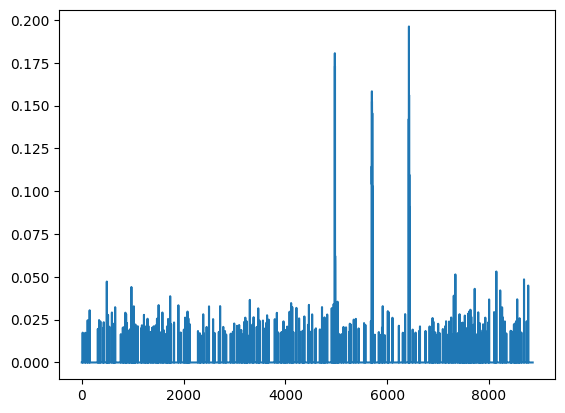

In [35]:
plt.plot(lsn.event_traces[1, start:end])

In [6]:
lsn_dff = LocallySparseNoise(sess, plane, response_trace_type="dff")

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_29321/505927982.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(figsize=(6, 2), ncols=2)


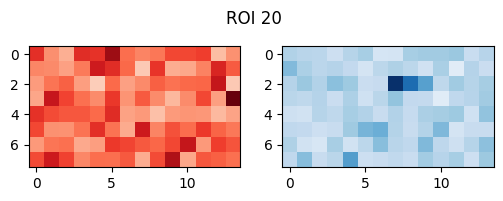

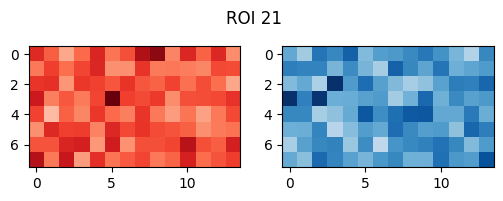

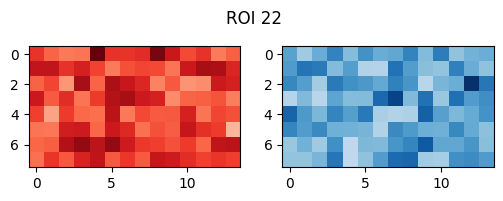

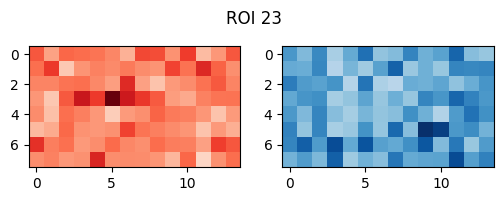

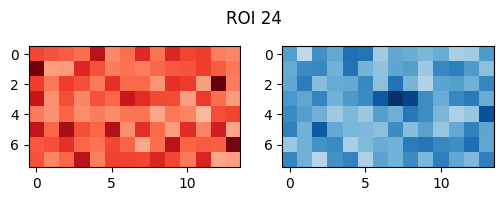

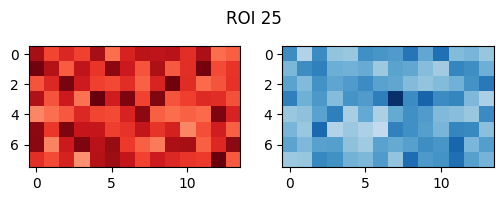

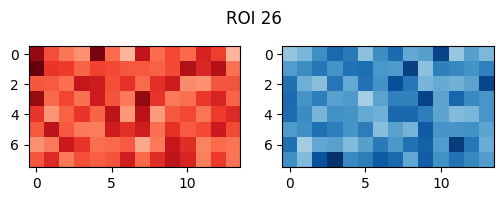

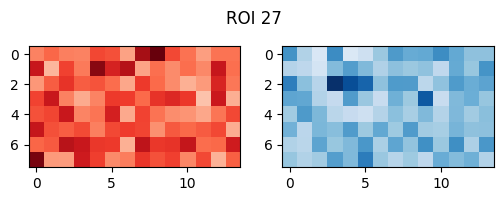

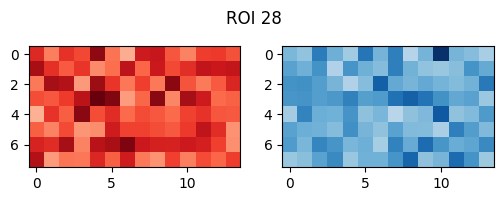

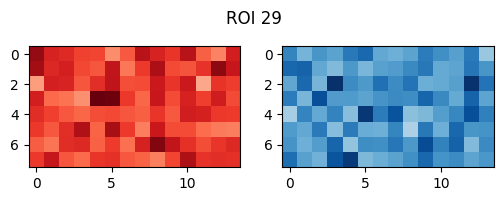

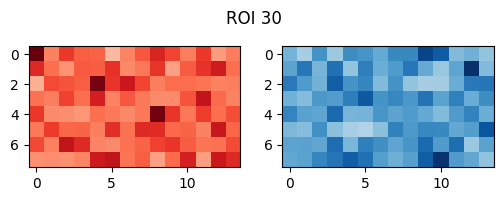

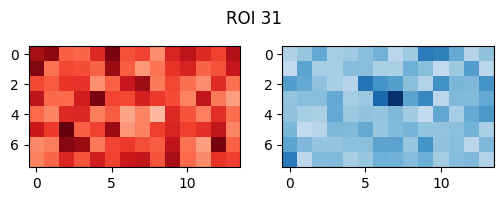

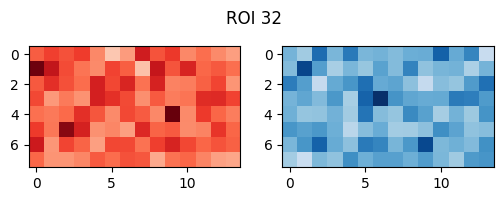

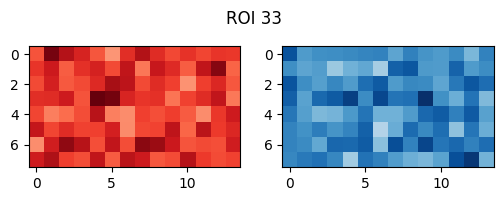

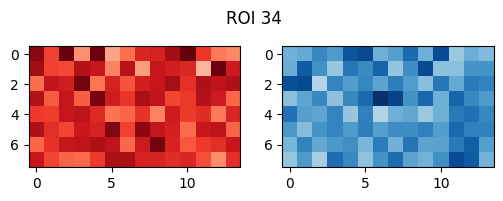

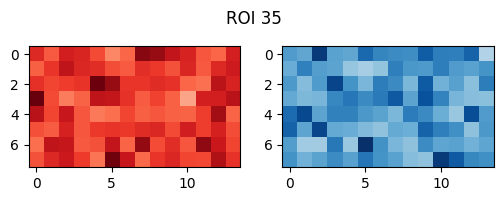

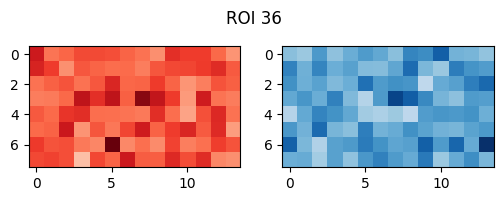

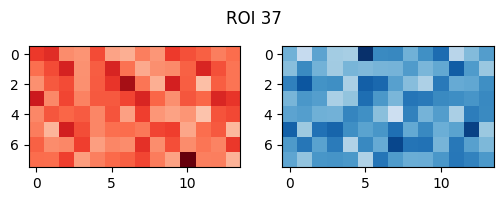

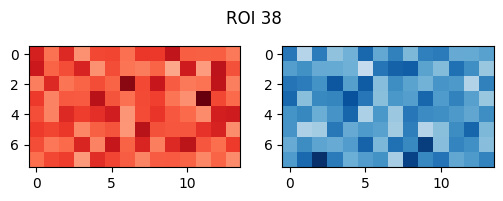

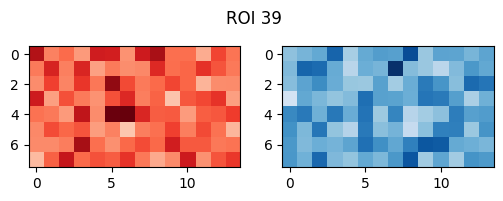

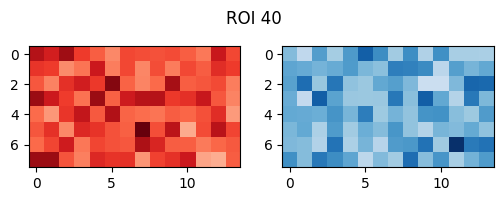

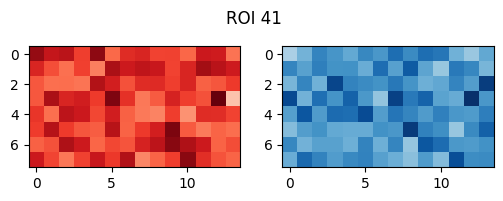

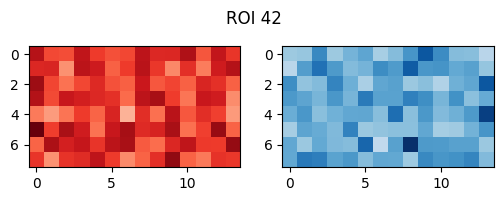

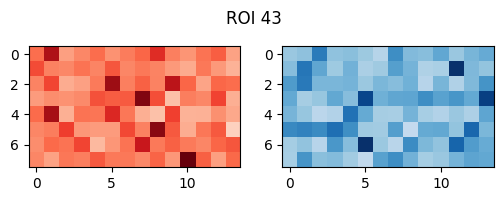

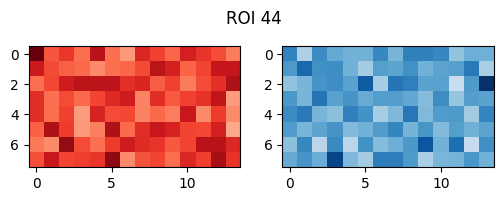

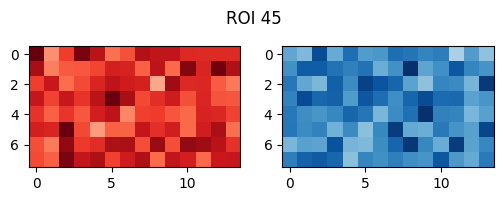

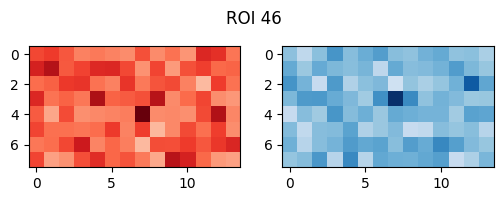

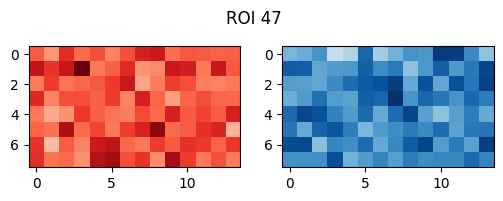

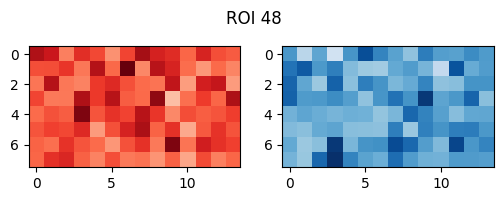

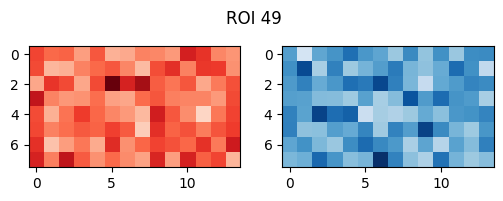

In [28]:
roi = 16 # strong ON field
# roi = 17 # strong OFF field
sweep_responses = np.where(lsn_dff.sweep_responses > 0, lsn_dff.sweep_responses, 0)
for roi in np.where(lsn.is_roi_valid)[0][20:50]:
    fig, axs = plt.subplots(figsize=(6, 2), ncols=2)
    axs[0].imshow(lsn.design_matrix.dot(sweep_responses)[:lsn.n_pixels, roi].reshape(lsn.image_shape), cmap="Reds", vmin=0)
    axs[1].imshow(lsn.design_matrix.dot(sweep_responses)[lsn.n_pixels:, roi].reshape(lsn.image_shape), cmap="Blues", vmin=0)
    fig.suptitle(f"ROI {roi}")

In [14]:
lsn_dff.sweep_responses

array([[ 0.03598362,  0.02936375,  0.48001608, ...,  0.00628969,
        -0.15535939,  0.01434967],
       [ 0.04305853,  0.0357755 ,  0.4190959 , ...,  0.07703123,
        -0.04732499,  0.00797749],
       [ 0.03500065,  0.00700648,  0.06450722, ...,  0.03583011,
        -0.06744488,  0.00324295],
       ...,
       [-0.01869949,  0.02650713, -0.06251612, ..., -0.00979268,
        -0.09414592, -0.09208889],
       [-0.01074888,  0.03088646,  0.01713924, ..., -0.0015941 ,
         0.0143548 , -0.09232696],
       [ 0.02363512, -0.05166301,  0.00653374, ...,  0.04730056,
         0.04156642, -0.10377769]], dtype=float32)

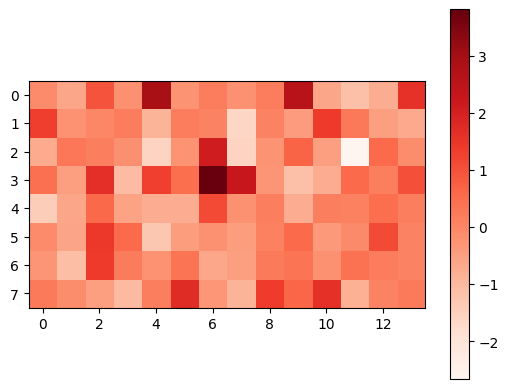

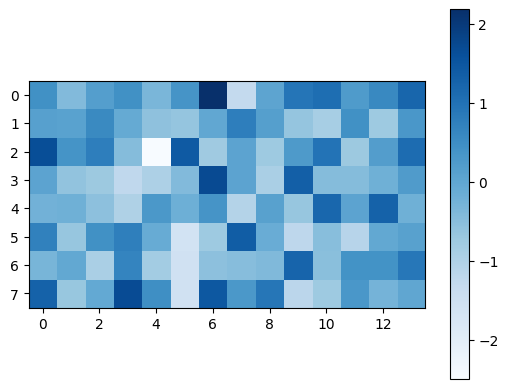

In [10]:
plt.imshow(lsn_dff.design_matrix.dot(lsn_dff.sweep_responses)[:lsn.n_pixels, roi].reshape(lsn.image_shape), cmap="Reds")
plt.colorbar()
plt.figure()
plt.imshow(lsn_dff.design_matrix.dot(lsn_dff.sweep_responses)[lsn.n_pixels:, roi].reshape(lsn.image_shape), cmap="Blues")
plt.colorbar()